In [1]:
# %autosave 0

In [2]:
import sys
from pathlib import Path
from os import getcwd
sys.path.append(str(Path(getcwd()).parent))
from os import remove


from datetime import date, timedelta
import codecs
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from os.path import join, basename

from bulletin import default_input, default_output, root
from bulletin.services.metabase import Metabase
from bulletin.systems.casos_confirmados import CasosConfirmados
from bulletin.systems.notifica import Notifica
from bulletin.utils.static import Municipios
from bulletin.utils.normalize import normalize_hash, normalize_labels, normalize_text, date_hash, normalize_number
from bulletin.utils import static
from bulletin.utils.xls_ import fit_cols

from datetime import datetime
import pyminizip as pz

today = datetime.today()
ontem = today - timedelta(1)
anteontem = ontem - timedelta(1)

municipios = Municipios()
municipios['mun_resid'] = municipios['municipio'].apply(normalize_text)
municipios.loc[municipios['uf']!='PR','mun_resid'] = municipios.loc[municipios['uf']!='PR','municipio'].apply(normalize_text) + '/' + municipios['uf']

import random
limite = 11878


---------------------------------------------------------------

root: /home/vinnylg/projects/covid19datascience/bulletin
parent: /home/vinnylg/projects/covid19datascience
default_input: /home/vinnylg/projects/covid19datascience/input
default_output: /home/vinnylg/projects/covid19datascience/output

---------------------------------------------------------------



In [3]:
mb = Metabase()
intervalo = "classificacao_final = 2 AND excluir_ficha = 2 AND status_notificacao in (1,2) AND ((data_notificacao >= NOW() - INTERVAL '7 DAY') or (data_liberacao >= NOW() - INTERVAL '7 DAY') or (updated_at >= NOW() - INTERVAL '7 DAY') or (data_coleta >= NOW() - INTERVAL '7 DAY') or (data_encerramento >= NOW() - INTERVAL '7 DAY'))"
mb.generate_notifica_query('update_notifica', where=intervalo)
mb.list_sql_files()

limit: 100000
Cookie:'c5d88********-****-****-****-************05b77'

sql_files:
	0: diario
	1: old_diario
	2: instituicao
	3: update_notifica
	4: new_query
	5: all_notifica
	6: coisa
	7: usecols_notifica
	8: comorbidades
	9: query_linda

sql_results:
	0: query_linda_len
	1: old_diario_len_202106152305
	2: update_notifica_len
	3: coisa_len_202106081128
	4: usecols_notifica_len_202106042312
	5: all_notifica_len_202106041103
	6: old_diario
	7: all_notifica
Select 44 columns

sql_files:
	0: diario
	1: old_diario
	2: instituicao
	3: update_notifica
	4: new_query
	5: all_notifica
	6: coisa
	7: usecols_notifica
	8: comorbidades
	9: query_linda


In [4]:
update_notifica = mb.download_notificacao('update_notifica', load=False, normalize=True)
update_notifica.save()
len(update_notifica.df)

Download update_notifica

Requesting csv
Success code 200
Saving query in /home/vinnylg/projects/covid19datascience/input/queries/update_notifica_len.csv
Download finish!
time elapsed: 0:00:09.998744
Columns size: 1


query_size: 39769

select ... limit 100000 offset 0

Requesting csv
Success code 200
Saving query in /home/vinnylg/projects/covid19datascience/input/queries/tmp/update_notifica_0_100000.csv
Download finish!
time elapsed: 0:00:01.941101
Columns size: 44

Reading /home/vinnylg/projects/covid19datascience/input/queries/tmp/update_notifica_0_100000.csv
normalize notifica
Attrb
39769
reading Notifica time elepsed:00:00:33
Download query time elepsed:00:00:51


39769

In [5]:
notifica = Notifica()
notifica.load()
notifica.update(update_notifica.df)
notifica.save()
len(notifica.df)

novas_notificacoes 65
possiveis_atualizacoes 39704


1192503

In [6]:
casos_notifica = notifica.df.drop_duplicates('hash', keep='last').copy()
casos_notifica.loc[casos_notifica['data_liberacao'].notna(),'hash_lib'] = casos_notifica.loc[casos_notifica['data_liberacao'].notna(),'paciente'].apply(normalize_hash) + casos_notifica.loc[casos_notifica['data_liberacao'].notna(),'data_liberacao'].apply(date_hash)
casos_notifica.loc[casos_notifica['data_diagnostico'].notna(),'hash_diag'] = casos_notifica.loc[casos_notifica['data_diagnostico'].notna(),'paciente'].apply(normalize_hash) + casos_notifica.loc[casos_notifica['data_diagnostico'].notna(),'data_diagnostico'].apply(date_hash)
casos_notifica = casos_notifica.loc[casos_notifica['data_diagnostico'].notna()]

In [7]:
casos_notifica = pd.merge(casos_notifica.rename(columns={'ibge_residencia':'ibge'}),municipios[['ibge','rs','mun_resid','uf','municipio']],on='ibge',how='left').rename(columns={'ibge':'ibge_residencia'})
casos_notifica = pd.merge(casos_notifica.rename(columns={'ibge_unidade_notifica':'ibge'}),municipios[['ibge','mun_resid']].rename(columns={'mun_resid':'mun_atend'}),on='ibge',how='left').rename(columns={'ibge':'ibge_unidade_notifica'})
casos_notifica = casos_notifica.loc[casos_notifica['rs'].notna()]
casos_notifica = casos_notifica.loc[casos_notifica['pais_residencia']==1]

casos_notifica = pd.merge(casos_notifica,pd.read_csv(join(root,'resources','tables','exame.csv')).rename(columns={'exame':'exame_name','id':'exame'}), on='exame', how='left')

casos_notifica = casos_notifica.loc[casos_notifica['sexo']!=3]
casos_notifica.loc[casos_notifica['sexo']==1,'sexo'] = 'M'
casos_notifica.loc[casos_notifica['sexo']==2,'sexo'] = 'F'

len(casos_notifica)

1180301

In [8]:
cc = CasosConfirmados()
cc.load(f"cc_{ontem.strftime('%d_%m_%Y')}")

databases: ['cc_13_06_2021', 'cc_14_06_2021', 'cc_15_06_2021', 'cc_17_06_2021', 'cc_18_06_2021', 'cc_21_05_2021', 'cc_22_05_2021', 'cc_23_05_2021', 'cc_25_05_2021', 'cc_27_05_2021', 'cc_28_05_2021', 'cc_29_05_2021']
Load /home/vinnylg/projects/covid19datascience/bulletin/database/casos_confirmados/cc_18_06_2021.pkl
loading Casos Confirmados from pkl time elepsed:00:00:01


In [9]:
casos_confirmados = cc.df
len(casos_confirmados)

1181439

In [10]:
casos_confirmados = pd.merge(casos_confirmados.rename(columns={'ibge_resid':'ibge'}),municipios,how='left',on='ibge').rename(columns={'ibge':'ibge_resid'})
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

,identificacao
evolucao,
1,830856
2,29674
3,320909


In [11]:
novos_casos = casos_notifica.loc[~(
    (casos_notifica['id'].isin(casos_confirmados['id_notifica'])) |
    (casos_notifica['hash'].isin(casos_confirmados['hash'])) |
    (casos_notifica['hash'].isin(casos_confirmados['hash_less'])) |
    (casos_notifica['hash'].isin(casos_confirmados['hash_more'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_less_atend'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_more_atend'])) |
    (casos_notifica['hash_diag'].isin(casos_confirmados['hash_diag'])) |
    (casos_notifica['hash_lib'].isin(casos_confirmados['hash_diag']))
)].copy()


novos_casos['data_com'] = pd.to_datetime(date.today())
novos_casos = novos_casos.sort_values(['data_diagnostico','paciente'])

len(novos_casos)

57718

<AxesSubplot:xlabel='data_diagnostico'>

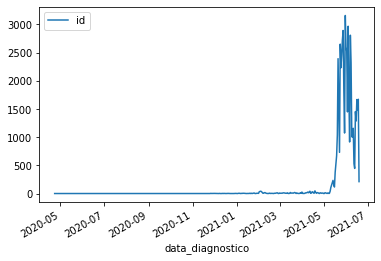

In [12]:
novos_casos[['id','data_diagnostico']].groupby('data_diagnostico').count().plot()

In [13]:
obitos_notifica = casos_notifica.loc[casos_notifica['evolucao']==2]
obitos_casos = casos_confirmados.loc[casos_confirmados['evolucao']==2]

novos_obitos = obitos_notifica.loc[~(
    (obitos_notifica['id'].isin(obitos_casos['id_notifica'])) |
    (obitos_notifica['hash'].isin(obitos_casos['hash'])) |
    (obitos_notifica['hash'].isin(obitos_casos['hash_less'])) |
    (obitos_notifica['hash'].isin(obitos_casos['hash_more'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_less_atend'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_more_atend'])) |
    (obitos_notifica['hash_diag'].isin(obitos_casos['hash_diag']))
)]

novos_obitos = novos_obitos.loc[novos_obitos['data_cura_obito'].notna()]
novos_obitos = novos_obitos.loc[novos_obitos['hash'].isin(casos_confirmados['hash'].tolist() + novos_casos['hash'].tolist())]
novos_obitos = novos_obitos.sort_values(['paciente'])

novos_obitos = novos_obitos.loc[novos_obitos['data_cura_obito'].notna()]
len(novos_obitos)

322

<AxesSubplot:xlabel='data_cura_obito'>

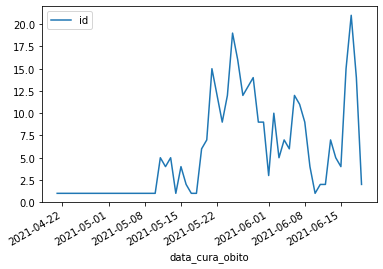

In [14]:
novos_obitos[['id','data_cura_obito']].groupby('data_cura_obito').count().plot()

In [15]:
dias_apos = [1,2,3,7,14,21,30,60,90]
dias_apos_label = ['hoje','24 horas','48 horas', '72 horas', '7 dias', '14 dias', '21 dias', '30 dias', '60 dias', '90 dias']

In [16]:
novos_obitos['dias_apos_obito'] = (today - novos_obitos['data_cura_obito']).dt.days
novos_obitos['periodo_obito'] = [ x for x in np.digitize(novos_obitos['dias_apos_obito'],dias_apos,right=False)]
periodo_novos_obitos = novos_obitos[['id','periodo_obito']].groupby('periodo_obito').count().rename(columns={'id':'qtde'})
periodo_novos_obitos['periodo'] = [ dias_apos_label[x] for x in periodo_novos_obitos.index ]
periodo_novos_obitos[['periodo','qtde']]

,periodo,qtde
periodo_obito,,
0,hoje,2
1,24 horas,14
2,48 horas,21
3,72 horas,31
4,7 dias,41
5,14 dias,49
6,21 dias,122
7,30 dias,42


In [17]:
novos_obitos[['id','paciente','sexo','idade','mun_resid', 'rs', 'data_cura_obito','hash']].to_excel(join(default_output,f"novos_obitos_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.xlsx"))

In [18]:
novos_casos['dias_apos_diagnostico'] = (today - novos_casos['data_diagnostico']).dt.days
novos_casos['periodo_diagnostico'] = [ x for x in np.digitize(novos_casos['dias_apos_diagnostico'],dias_apos,right=False)]
periodo_novos_casos = novos_casos[['id','periodo_diagnostico']].groupby('periodo_diagnostico').count().rename(columns={'id':'qtde'})
periodo_novos_casos['periodo'] = [ dias_apos_label[x] for x in periodo_novos_casos.index ]
periodo_novos_casos[['periodo','qtde']]

,periodo,qtde
periodo_diagnostico,,
0,hoje,212
1,24 horas,1673
2,48 horas,1479
3,72 horas,4855
4,7 dias,9741
5,14 dias,15515
6,21 dias,19443
7,30 dias,3748
8,60 dias,430


In [19]:
novos_casos_alterado = novos_casos.loc[novos_casos['evolucao']==2]

novos_casos = novos_casos.drop(index=novos_casos_alterado.index)

novos_casos_ate_72_horas = novos_casos.loc[novos_casos['periodo_diagnostico'] <= 3 ]
novos_casos_apos_72_horas = novos_casos.loc[novos_casos['periodo_diagnostico'] > 3 ]

novos_casos_alterado = novos_casos_alterado.append(novos_casos_ate_72_horas)

print(f"{len(novos_casos_alterado)} novos_casos_ate_72_horas + obitos")

novos_casos_apos_72_horas_para_adicionar = novos_casos_apos_72_horas.sample(n=limite - len(novos_casos_alterado))

novos_casos_apos_72_horas = novos_casos_apos_72_horas.drop(index=novos_casos_apos_72_horas_para_adicionar.index)

if len(novos_casos_alterado) < limite:
    novos_casos_alterado = novos_casos_alterado.append(novos_casos_apos_72_horas_para_adicionar)
    
print(f"{len(novos_casos_apos_72_horas_para_adicionar)} novos_casos_apos_72_horas_para_adicionar")
print(f"faltam {len(novos_casos_apos_72_horas)} novos_casos_apos_72_horas_para_adicionar")


8390 novos_casos_ate_72_horas + obitos
3488 novos_casos_apos_72_horas_para_adicionar
faltam 45840 novos_casos_apos_72_horas_para_adicionar


<AxesSubplot:xlabel='data_diagnostico'>

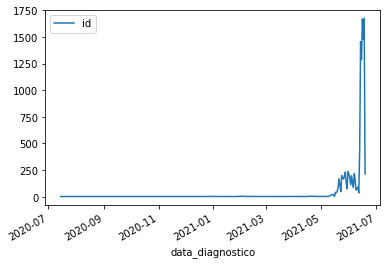

In [20]:
novos_casos = novos_casos_alterado
novos_casos[['id','data_diagnostico']].groupby('data_diagnostico').count().plot()

In [21]:
novos_casos[['id','paciente','sexo','idade','mun_resid', 'mun_atend', 'rs', 'exame_name','data_diagnostico','data_com','data_1o_sintomas','hash']].to_excel(join(default_output,f"novos_casos_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.xlsx"))

In [22]:
print(len(casos_confirmados), end=' ')
duplicados = casos_confirmados.loc[casos_confirmados.duplicated('hash',keep='first')]
print(f" - {len(duplicados)} ", end='= ')
casos_confirmados = casos_confirmados.drop(index=duplicados.index)
print(len(casos_confirmados))
duplicados.to_excel(join(default_output,'exclusoes.xlsx'))

1181439  - 381 = 1181058


In [23]:
date_parser = lambda x: x
relatorio_file = join(default_output,f"relatorio_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.txt")
# relatorio_file = join(default_output,f"relatorio_all.txt")
relatorio_file

'/home/vinnylg/projects/covid19datascience/output/relatorio_19_06_2021_11h.txt'

In [24]:
casos_confirmadosPR = casos_confirmados.loc[casos_confirmados['rs']!=99]

obitos_confirmados =  casos_confirmados.loc[casos_confirmados['evolucao']==2]

obitos_confirmadosPR = obitos_confirmados.loc[obitos_confirmados['rs']!=99]

print(f"Total de casos: {len(casos_confirmados)} + {len(novos_casos)}")
print(f"Total de obitos: {len(obitos_confirmados)} + {len(novos_obitos)}\n\n")

novos_casosPR = novos_casos.loc[novos_casos['rs']!=99].copy()
print(f"Total de casos PR: {len(casos_confirmadosPR)} + {len(novos_casosPR)}")

novos_obitosPR = novos_obitos.loc[novos_obitos['rs']!=99].copy()
print(f"Total de obitos PR: {len(obitos_confirmadosPR)} + {len(novos_obitosPR)}")

novos_casosFora = novos_casos.loc[novos_casos['rs']==99].copy()
print(f"Total de casos Fora: {len(casos_confirmados) - len(casos_confirmadosPR)} + {len(novos_casosFora)}")

novos_obitosFora = novos_obitos.loc[novos_obitos['rs']==99].copy()
print(f"Total de obitos Fora: {len(obitos_confirmados) - len(obitos_confirmadosPR)} + {len(novos_obitosFora)}")


novos_obitosPR_group = novos_obitosPR.groupby(by='municipio')

data_retroativos = ontem - timedelta(14)

retroativos = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) <= data_retroativos)].sort_values(by='data_diagnostico')
last2weeks = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) > data_retroativos) & (novos_casosPR['data_diagnostico'].apply(date_parser) <= anteontem)].sort_values(by='data_diagnostico')
hoje = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) > anteontem)].sort_values(by='data_diagnostico')

obitos_retroativos = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) <= data_retroativos)].sort_values(by='data_cura_obito')
obitos_last2weeks = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) > data_retroativos) & (novos_obitosPR['data_cura_obito'].apply(date_parser) <= anteontem)].sort_values(by='data_cura_obito')
obitos_hoje = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) > anteontem)].sort_values(by='data_cura_obito')

# relatorio_file = join(default_output,f"relatorio_{(today.strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.txt")
with codecs.open(relatorio_file,"w","utf-8-sig") as relatorio:
    relatorio.write(f"{today.strftime('%d/%m/%Y')}\n")
    relatorio.write(f"{len(novos_casosPR):,} novos casos residentes ".replace(',','.'))

    if len(novos_casosFora) > 0:
        relatorio.write(f"e {len(novos_casosFora):,} não residente{'s' if len(novos_casosFora) > 1 else ''} ".replace(',','.'))
    relatorio.write(f"divulgados no PR.\n")

    relatorio.write(f"{len(casos_confirmadosPR)+len(novos_casosPR):,} casos confirmados residentes do PR.\n".replace(',','.'))
    relatorio.write(f"{len(casos_confirmados)+len(novos_casos):,} total geral.\n\n".replace(',','.'))
    relatorio.write(f"{len(novos_obitosPR):,} Óbitos residentes do PR:\n".replace(',','.'))

    for municipio, obitos in novos_obitosPR_group:
        relatorio.write(f"{len(obitos):,} {municipio}\n".replace(',','.'))

    if len(novos_obitosFora) > 0:
        relatorio.write('\n')
        relatorio.write(f"{len(novos_obitosFora):,} Óbito{'s' if len(novos_obitosFora) > 1 else ''} não residente{'s' if len(novos_obitosFora) > 1 else ''} do PR.\n".replace(',','.'))

    relatorio.write('\n')
    relatorio.write(f"{len(obitos_confirmadosPR)+len(novos_obitosPR):,} óbitos residentes do PR.\n".replace(',','.'))
    relatorio.write(f"{len(obitos_confirmados)+len(novos_obitos):,} total geral.\n\n".replace(',','.'))

    for _, row in novos_obitos.iterrows():
       relatorio.write(f"{row['sexo']}\t{int(row['idade'])}\t{row['municipio'] if row['rs']!=99 else (row['municipio']+'/'+row['uf'])}\t{str(int(row['rs'])).zfill(2) if row['rs']!=99 else '#N/D'}\t{row['data_cura_obito'].day}/{static.meses[row['data_cura_obito'].month-1]}/{row['data_cura_obito'].year}\n")
    relatorio.write('\n')

    if True:

        #casos
        relatorio.write(f"{len(novos_casosPR):,} novos casos residentes divulgados no PR.\n".replace(',','.'))

        relatorio.write(f"{len(retroativos):,} casos retroativos confirmados no período de {retroativos.iloc[0]['data_diagnostico'].strftime('%d/%m/%Y')} à {retroativos.iloc[-1]['data_diagnostico'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(last2weeks):,} novos casos confirmados no período de {last2weeks.iloc[0]['data_diagnostico'].strftime('%d/%m/%Y')} à {last2weeks.iloc[-1]['data_diagnostico'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(hoje):,} novos casos confirmados hoje.\n\n".replace(',','.'))


        novos_casosPR['month'] = novos_casosPR.apply(lambda x: x['data_diagnostico'].month, axis=1)
        novos_casosPR['year'] = novos_casosPR.apply(lambda x: x['data_diagnostico'].year, axis=1)
        relatorio.write('Novos casos por meses:\n')
        for group, value in novos_casosPR.groupby(by=['year','month']):
            relatorio.write(f"{static.meses[int(group[1])-1]}\\{group[0]}: {len(value)}\n")
        relatorio.write('\n')
        
        relatorio.write('Novos casos por dia:\n')
        for group, value in novos_casosPR.groupby(by='data_diagnostico'):
            relatorio.write(f"{group.strftime('%d/%m/%Y')}\t{len(value)}\n")
        relatorio.write('\n')

        #obitos
        relatorio.write(f"{len(novos_obitosPR):,} novos obitos residentes divulgados no PR.\n".replace(',','.'))

        relatorio.write(f"{len(obitos_retroativos):,} obitos retroativos ocorridos no período de {obitos_retroativos.iloc[0]['data_cura_obito'].strftime('%d/%m/%Y')} à {obitos_retroativos.iloc[-1]['data_cura_obito'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(obitos_last2weeks):,} novos obitos ocorridos no período de {obitos_last2weeks.iloc[0]['data_cura_obito'].strftime('%d/%m/%Y')} à {obitos_last2weeks.iloc[-1]['data_cura_obito'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(obitos_hoje):,} novos obitos ocorridos hoje.\n\n".replace(',','.'))

        relatorio.write('Novos obitos por meses:\n')
        novos_obitosPR['month'] = novos_obitosPR.apply(lambda x: x['data_cura_obito'].month, axis=1)
        novos_obitosPR['year'] = novos_obitosPR.apply(lambda x: x['data_cura_obito'].year, axis=1)
        for group, value in novos_obitosPR.groupby(by=['year','month']):
            relatorio.write(f"{static.meses[int(group[1])-1]}\\{group[0]}: {len(value)}\n")
        relatorio.write('\n')

        relatorio.write('Novos obitos por dia:\n')
        for group, value in novos_obitosPR.groupby(by='data_cura_obito'):
            relatorio.write(f"{group.strftime('%d/%m/%Y')}\t{len(value)}\n")
        relatorio.write('\n')

        #-----RELATÓRIO DA COMUNICAÇÃO--------------
        obitos_list = []
        munic = []
        for municipio, obitos in novos_obitosPR_group:
            obito = len(obitos)
            obitos_list.append(obito)
            munic.append(municipio)             

        dicionario = (dict(zip(list(munic),list(obitos_list))))
        #print(dicionario)
        dicionario = sorted(dicionario.items(),key=lambda x: x[1], reverse = True)
        #print(dicionario)


        relatorio.write(f"\nOs pacientes que foram a óbito residiam em: ")
        for municip, obit in dict(dicionario).items():
            if obit != 1:
                relatorio.write(f"{municip} ({obit})")
                relatorio.write(f", ")
        relatorio.write(f".\n")
        relatorio.write(f"A Sesa registra ainda a morte de uma pessoa que residia em cada um dos seguintes municípios:")
        for municip, obit in dict(dicionario).items():
            if obit == 1:
                relatorio.write(f"{municip}")
                relatorio.write(f", ")


Total de casos: 1181058 + 11878
Total de obitos: 29674 + 322


Total de casos PR: 1174748 + 11835
Total de obitos PR: 29508 + 320
Total de casos Fora: 6310 + 43
Total de obitos Fora: 166 + 2


In [25]:
with codecs.open(relatorio_file,"r","utf-8-sig") as relatorio:
    print(relatorio.read())

19/06/2021
11.835 novos casos residentes e 43 não residentes divulgados no PR.
1.186.583 casos confirmados residentes do PR.
1.192.936 total geral.

320 Óbitos residentes do PR:
1 Almirante Tamandaré
1 Alto Paraíso
3 Altônia
2 Antonina
1 Antônio Olinto
18 Apucarana
7 Arapongas
5 Araucária
1 Bandeirantes
1 Bom Sucesso
1 Cafeara
1 Califórnia
1 Cambará
1 Cambira
1 Cambé
4 Campina da Lagoa
1 Campo Largo
8 Campo Mourão
1 Carlópolis
3 Cascavel
3 Cerro Azul
1 Cianorte
1 Clevelândia
5 Colombo
2 Cruz Machado
3 Cruzeiro do Oeste
44 Curitiba
1 Dois Vizinhos
1 Fazenda Rio Grande
16 Foz do Iguaçu
1 Francisco Beltrão
3 General Carneiro
3 Goioerê
10 Guarapuava
1 Guaíra
3 Ibaiti
1 Ibema
2 Imbituva
1 Ivaiporã
1 Jaguariaíva
3 Lapa
2 Laranjeiras do Sul
22 Londrina
1 Mandaguari
1 Mandaguaçu
1 Manoel Ribas
1 Marialva
15 Maringá
1 Mariópolis
1 Medianeira
1 Miraselva
2 Nova Esperança
2 Nova Fátima
1 Nova Londrina
1 Nova Prata do Iguaçu
1 Nova Santa Rosa
2 Paiçandu
2 Palmas
1 Palmital
1 Paranacity
4 Paranaguá

In [26]:
import time

while True:
    time.sleep(0.05)
    print('a',end='')


aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

KeyboardInterrupt: 

In [ ]:
cc = CasosConfirmados()
cc.load(f"cc_{ontem.strftime('%d_%m_%Y')}")
casos_confirmados = cc.df
print(len(casos_confirmados))
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

In [ ]:
novos_casos = novos_casos.rename(columns={
    'id':'id_notifica',
    'ibge_residencia': 'ibge_resid',
    'ibge_unidade_notifica': 'ibge_atend',
    'paciente':'nome',
    'sexo': 'sexo',
    'idade':'idade',
    'exame': 'laboratorio',
    'data_diagnostico':'dt_diag',
    'data_com':'comunicacao',
    'data_1o_sintomas': 'is',
    'evolucao': 'evolucao',
    'data_cura_obito': 'data_evolucao',
    'uf': 'uf_resid'
})

novos_casos = novos_casos[['id_notifica', 'uf_resid', 'ibge_resid', 'ibge_atend', 'nome', 'sexo', 'idade', 'laboratorio', 'dt_diag', 'comunicacao', 'is', 'evolucao', 'data_evolucao']]

novos_casos.loc[novos_casos['evolucao']==5,'evolucao'] = 2
novos_casos.loc[~novos_casos['evolucao'].isin([1,2,3]),'evolucao'] = 3
novos_casos.loc[novos_casos['evolucao']==2,'evolucao'] = 3

novos_casos['hash'] = (novos_casos['nome'].apply(normalize_hash) +
                  novos_casos['idade'].astype(int).astype(str) +
                  novos_casos['ibge_resid'].astype(int).astype(str) )

novos_casos['hash_less'] = ( novos_casos['nome'].apply(normalize_hash) +
                        novos_casos['idade'].apply(lambda x: str(x - 1)) +
                        novos_casos['ibge_resid'].astype(str) )

novos_casos['hash_more'] = ( novos_casos['nome'].apply(normalize_hash) +
                        novos_casos['idade'].apply(lambda x: str(x + 1)) +
                        novos_casos['ibge_resid'].astype(str) )

novos_casos['hash_atend'] = (novos_casos['nome'].apply(normalize_hash) +
                    novos_casos['idade'].astype(str) +
                    novos_casos['ibge_atend'].apply(str) )

novos_casos['hash_less_atend'] = (novos_casos['nome'].apply(normalize_hash) +
                    novos_casos['idade'].apply(lambda x: str(x-1)) +
                    novos_casos['ibge_atend'].apply(str) )

novos_casos['hash_more_atend'] = (novos_casos['nome'].apply(normalize_hash) +
                    novos_casos['idade'].apply(lambda x: str(x+1)) +
                    novos_casos['ibge_atend'].apply(str) )

novos_casos['identificacao'] = list(range(casos_confirmados.iloc[-1,0] + 1,casos_confirmados.iloc[-1,0] + 1 + len(novos_casos)))

casos_confirmados = casos_confirmados.append(novos_casos)
print(len(casos_confirmados))
# casos_confirmados.groupby('evolucao')[['sexo']].count()
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

In [ ]:
casos_confirmados.loc[casos_confirmados['hash'].isin(novos_obitos['hash'])]

In [ ]:
novos_obitos = novos_obitos.rename(columns={
    'id': 'id_notifica',
    'data_cura_obito': 'data_evolucao',
    'paciente':'nome'
})

novos_obitos['data_com_evolucao'] = pd.to_datetime(date.today())
novos_obitos['evolucao'] = 2

novos_obitos = novos_obitos[['hash','id_notifica','evolucao','data_evolucao','data_com_evolucao']]
novos_obitos = novos_obitos.set_index('hash')
novos_obitos

In [ ]:
casos_confirmados = casos_confirmados.set_index('hash')
casos_confirmados.update(novos_obitos)
casos_confirmados.reset_index(inplace=True)

print(len(casos_confirmados))
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

In [ ]:
novos_obitos = novos_obitos.reset_index()
novos_obitos.loc[novos_obitos.duplicated('hash',keep=False)]

In [ ]:
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

In [ ]:
# cc.df = casos_confirmados[['identificacao','id_notifica','uf_resid','ibge_resid','ibge_atend','nome','sexo','idade','laboratorio','dt_diag','comunicacao','is','evolucao','data_evolucao','data_com_evolucao','hash','hash_less','hash_more','hash_atend','hash_less_atend','hash_more_atend','hash_diag']]
# cc.df
casos_confirmados.loc[casos_confirmados['hash'].isin(novos_obitos.index.tolist())]

In [ ]:
cc.df = casos_confirmados[['identificacao','id_notifica','uf_resid','ibge_resid','ibge_atend','nome','sexo','idade','laboratorio','dt_diag','comunicacao','is','evolucao','data_evolucao','data_com_evolucao','hash','hash_less','hash_more','hash_atend','hash_less_atend','hash_more_atend','hash_diag']]
cc.save(f"cc_{today.strftime('%d_%m_%Y')}", replace=True)
cc.df.tail()

In [ ]:
casos_confirmados = cc.df
casos_confirmados

In [ ]:
municipios = Municipios()

macros_idx_labels = dict([ [i,x] for (i,x) in enumerate(['Leste','Oeste','Noroeste','Norte','Fora'])])
macros_labels_idx = dict([ [x,i] for (i,x) in macros_idx_labels.items() ])
municipios['macro'] = municipios['macro'].apply(lambda x: macros_labels_idx[x])

casos_confirmados = pd.merge(casos_confirmados.rename(columns={'ibge_resid':'ibge'}),municipios,on=['ibge'],how='left').rename(columns={'ibge':'ibge_resid'})

casos_confirmados['municipio_pr'] = casos_confirmados['municipio']
casos_confirmados.loc[casos_confirmados['uf_resid']!='PR','municipio_pr'] = 'Fora'

casos_confirmados.loc[casos_confirmados['uf_resid']!='PR','ibge7'] = 9999999

casos_confirmados['uf_pr'] = 'PR'
casos_confirmados.loc[casos_confirmados['uf_resid']!='PR','uf_pr'] = 'Fora'

In [ ]:
pd.options.display.float_format = lambda x: '{:,.0f}'.format(x).replace(',','.')

total = casos_confirmados.groupby(['evolucao','uf_pr'])[['sexo']].count().unstack().droplevel(0,1)[['PR','Fora']]
total['GERAL'] = total.sum(1)
total = total.append(pd.Series(total.sum(0),name=0))
total.index = [2,1,3,0]
total = total.sort_index()
total = total.rename(index={0:'CASOS',2:'RECUPERADOS',1:'OBITOS',3:'ATIVOS'})
total.index.name = None
total.columns.name = None

total.astype(float)

In [ ]:
total_macros = casos_confirmados.groupby(['macro','evolucao'])[['sexo']].count().unstack()
total_macros.columns = total_macros.columns.droplevel(0)

total_macros['CASOS'] = total_macros.sum(1)
total_macros = total_macros.fillna(0)
total_macros = total_macros.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_macros = total_macros[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_macros.index = [ macros_idx_labels[x] if isinstance(x,int) else x for x in total_macros.index]

total_macros.astype(float)

In [ ]:
total_regionais = casos_confirmados.groupby(['rs','regional','evolucao'])[['sexo']].count().unstack()
total_regionais.columns = total_regionais.columns.droplevel(0)

total_regionais['CASOS'] = total_regionais.sum(1)
total_regionais = total_regionais.fillna(0)
total_regionais = total_regionais.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_regionais = total_regionais[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_regionais.astype(float)

In [ ]:
total_municipios = casos_confirmados.groupby(['macro','rs','regional','ibge7','municipio_pr','evolucao'])[['sexo']].count().unstack()

total_municipios[('','CASOS')] = total_municipios.sum(1)
total_municipios = total_municipios.fillna(0).astype(float)
total_municipios.columns = total_municipios.columns.droplevel(0)
total_municipios = total_municipios.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_municipios = total_municipios[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_municipios.index = total_municipios.index.set_levels([ macros_idx_labels[x] if isinstance(x,int) else x for x in total_municipios.index.levels[0]], level=0)

total_municipios

In [ ]:
total_municipios.loc[(slice(None),slice(None),slice(None),slice(None),'Curitiba')]

In [ ]:
ministerio_cols = ['ibge7','municipio_pr','macro','CASOS','OBITOS']

ministerio_sort = pd.read_csv(join(default_input,'ministerio_ibge_order.csv'), sep=';')

ministerio = pd.merge(ministerio_sort, total_municipios.reset_index()[ministerio_cols], how='left', on='ibge7' )
del ministerio['ibge7']

ministerio['macro'] = ministerio['macro'].str.upper()

ministerio.loc[399,['municipio_pr']] = 'Fora do Parana'
ministerio.loc[399,['macro']] = ''

ministerio.loc[400,'municipio_pr'] = 'TOTAL GERAL'
ministerio.loc[400,'macro'] = ''
ministerio.loc[400,'CASOS'] = total.loc['CASOS','GERAL']
ministerio.loc[400,'OBITOS'] = total.loc['OBITOS','GERAL']

ministerio.columns = ['Município de residência', 'macro', 'Casos confirmados', 'Óbitos']

writer = pd.ExcelWriter(join(default_output,"Casos confirmados covid19 no PR por município.xlsx"),
                    engine='xlsxwriter')

ministerio.to_excel(writer,'total_municipios', index=False)
fit_cols(writer,ministerio,'total_municipios')

writer.save()

from openpyxl import load_workbook
from openpyxl.styles import Alignment, PatternFill

wb = load_workbook(filename = join(default_output,"Casos confirmados covid19 no PR por município.xlsx"))
sheet = wb['total_municipios']
sheet.insert_rows(1)
sheet.merge_cells(start_row=1, start_column=1, end_row=1, end_column=4)
cell = sheet.cell(row=1, column=1)  
cell.value = 'Casos confirmados covid-19 no Paraná'  
cell.alignment = Alignment(horizontal='center', vertical='center')  
wb.save(filename = join(default_output,"Casos confirmados covid19 no PR por município.xlsx"))

ministerio

In [ ]:
casos_confirmados['regional'] = casos_confirmados['rs'].apply(lambda x: str(x).zfill(2)) +'ª '+ casos_confirmados['regional']
casos_confirmados = casos_confirmados[['id_notifica','macro','regional','ibge_resid','municipio','ibge_atend','nome','sexo','idade', 'laboratorio', 'dt_diag', 'comunicacao', 'is', 'evolucao','data_evolucao', 'data_com_evolucao']].copy()
casos_confirmados.loc[casos_confirmados['evolucao']==1,'evolucao'] = 'CURA'
casos_confirmados.loc[casos_confirmados['evolucao']==2,'evolucao'] = 'OBITO'
casos_confirmados.loc[casos_confirmados['evolucao']==3,'evolucao'] = 'ATIVO'

In [ ]:
obitos_confirmados = casos_confirmados.loc[casos_confirmados['evolucao']=='OBITO']

In [ ]:
writer = pd.ExcelWriter(join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for idx, macro in macros_idx_labels.items():
    casos_macro = casos_confirmados.loc[casos_confirmados['macro']==idx].copy()
    casos_macro['macro'] = macro
    casos_macro.to_excel(writer,macro)
    fit_cols(writer,casos_macro,macro)


writer.save()

In [ ]:
writer = pd.ExcelWriter(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for idx, macro in macros_idx_labels.items():
    casos_macro = obitos_confirmados.loc[obitos_confirmados['macro']==idx].copy()
    casos_macro['macro'] = macro
    casos_macro.to_excel(writer,macro)
    fit_cols(writer,casos_macro,macro)


writer.save()

In [ ]:
# casos_confirmados['rs'].unique()

In [ ]:
writer = pd.ExcelWriter(join(default_output,f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for regional in sorted(casos_confirmados['regional'].unique()):
    casos_regional = casos_confirmados.loc[casos_confirmados['regional']==regional].copy()
    casos_regional['macro'] = casos_regional['macro'].apply(lambda x: macros_idx_labels[x])
    casos_regional.to_excel(writer,regional)
    fit_cols(writer,casos_regional,regional)


writer.save()

In [ ]:
writer = pd.ExcelWriter(join(default_output,f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for regional in sorted(obitos_confirmados['regional'].unique()):
    obitos_regional = obitos_confirmados.loc[obitos_confirmados['regional']==regional].copy()
    obitos_regional['macro'] = obitos_regional['macro'].apply(lambda x: macros_idx_labels[x])
    obitos_regional.to_excel(writer,regional)
    fit_cols(writer,obitos_regional,regional)


writer.save()

In [ ]:
# REMOVE ARQUIVOS DE ONTEM
try:
    remove(join(default_output, f"casos_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"obitos_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"casos_regionais_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"obitos_regionais_{ontem.strftime('%d_%m_%Y')}.xlsx"))

    remove(join(default_output, f"casos_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"obitos_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"casos_regionais_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"obitos_regionais_{ontem.strftime('%d_%m_%Y')}.zip"))
except:
    pass

# GERA ARQUIVOS COMPACTADOS DE HOJE

paths = [join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx")]
paths.append(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"))
paths.append(join(default_output, f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))
paths.append(join(default_output, f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))

for path in paths:
    pz.compress(path, None, join(default_output, f"{basename(path)}.zip".replace(".xlsx", "")), "Jt\j+ZXVOAbSw*i&J)ZePVGiQgU4wc", 9)


# REMOVE ARQUIVOS XLSX DE HOJE
remove(join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))